In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score
from sklearn.model_selection import train_test_split
from scipy import stats

# Load dataset
df = pd.read_csv("raw_ccr_revenue.csv")

df.head()

,HOTEL_ID,HOTEL_CATEGORY,BOOKING_CHANNEL,DISTANCE_TO_STATION,SEASON,IS_CCR_RATE_TYPE,HOTEL_REVENUE,AVG_DISCOUNT,SATISFACTION_SCORE
0,1176522,3,Portal (HRS),2.0,Summer,0,1090.970,0.0,9.0
1,1176522,3,Portal (HRS),2.0,Autumn,0,92.070,0.0,6.0
2,1176522,3,Portal (HRS),2.0,Spring,0,156.240,0.0,9.0
3,1176521,5,Portal (HRS),2.0,Summer,0,1506.160,0.0,5.0
4,1176176,5,Mobile (HRS),15.0,Autumn,0,90.082,0.0,10.0


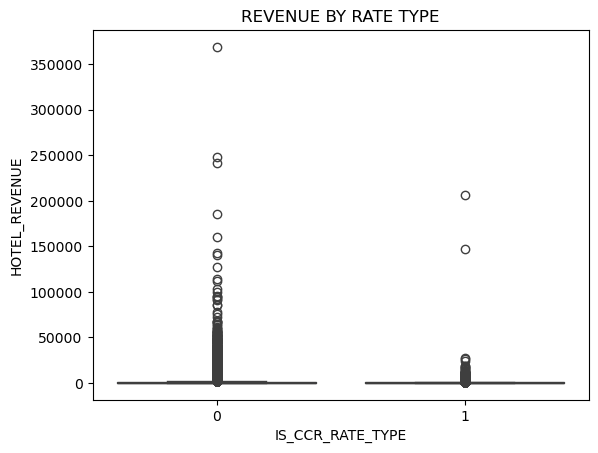

In [2]:
sns.boxplot(data=df, x='IS_CCR_RATE_TYPE', y='HOTEL_REVENUE')
plt.title('REVENUE BY RATE TYPE')
plt.show()

At first glance it seems that CCR rate doesn't help increase revenue for hotels, because the density of data points for revenue where CCR = 1 is < 50,000, while that's not the case with CCR = 0

**Check for potential confounders - understand what could bias results. Examples:**
Do customers simply choose hotels near train stations, thus increase the revenue in those hotels?
Do hotels with deeper discount attract more bookings, hence increase revenue?

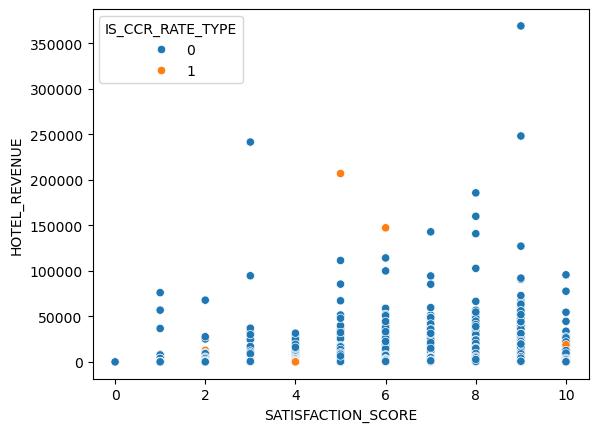

In [3]:
#Distance to station:
#sns.scatterplot(x='DISTANCE_TO_STATION', y='HOTEL_REVENUE', hue='IS_CCR_RATE_TYPE', data=df)
#plt.show();

#Booking channel:
#channel_plot = sns.scatterplot(x='BOOKING_CHANNEL', y='HOTEL_REVENUE', hue='IS_CCR_RATE_TYPE', data=df)
#channel_plot.set_xticklabels(channel_plot.get_xticklabels(), rotation=45)
#plt.show();

#Hotel category:
#sns.scatterplot(x='HOTEL_CATEGORY', y='HOTEL_REVENUE', hue='IS_CCR_RATE_TYPE', data=df)
#plt.show();

#Discount:
#sns.scatterplot(x='AVG_DISCOUNT', y='HOTEL_REVENUE', hue='IS_CCR_RATE_TYPE', data=df)
#plt.show();

#Satisfaction:
sns.scatterplot(x='SATISFACTION_SCORE', y='HOTEL_REVENUE', hue='IS_CCR_RATE_TYPE', data=df)
plt.show();

High satisfaction and short distance to station seem to correlate with higher hotel revenue.

In [4]:
df.drop('BOOKING_CHANNEL', axis = 1)
df.describe()

,HOTEL_ID,HOTEL_CATEGORY,DISTANCE_TO_STATION,IS_CCR_RATE_TYPE,HOTEL_REVENUE,AVG_DISCOUNT,SATISFACTION_SCORE
count,1.745860e+05,174586.000000,174586.000000,174586.000000,174586.000000,174586.000000,174586.000000
mean,3.186280e+05,3.374245,8.739406,0.112632,987.507961,0.010091,8.123389
std,3.299229e+05,0.712494,110.451217,0.316144,2814.723579,0.022489,1.545751
min,1.000000e+00,1.000000,0.000000,0.000000,1.980000,0.000000,0.000000
25%,3.918450e+04,3.000000,1.000000,0.000000,152.876500,0.000000,8.000000
50%,1.619725e+05,3.000000,3.000000,0.000000,368.000000,0.000000,8.000000
75%,5.449182e+05,4.000000,9.000000,0.000000,946.315000,0.010000,9.000000
max,1.176522e+06,5.000000,13982.000000,1.000000,369025.100000,1.370000,10.000000


In [5]:
# Preprocess dataset
# Convert categorical variables to categorical type
df['SEASON'] = df['SEASON'].astype('category')

In [6]:
# Encode categorical variables
df = pd.get_dummies(df, columns=['SEASON'], drop_first = True)
#data = pd.get_dummies(data, columns=['BOOKING_RATE_TYPE'])

df.head()

,HOTEL_ID,HOTEL_CATEGORY,BOOKING_CHANNEL,DISTANCE_TO_STATION,IS_CCR_RATE_TYPE,HOTEL_REVENUE,AVG_DISCOUNT,SATISFACTION_SCORE,SEASON_Spring,SEASON_Summer,SEASON_Winter
0,1176522,3,Portal (HRS),2.0,0,1090.970,0.0,9.0,False,True,False
1,1176522,3,Portal (HRS),2.0,0,92.070,0.0,6.0,False,False,False
2,1176522,3,Portal (HRS),2.0,0,156.240,0.0,9.0,True,False,False
3,1176521,5,Portal (HRS),2.0,0,1506.160,0.0,5.0,False,True,False
4,1176176,5,Mobile (HRS),15.0,0,90.082,0.0,10.0,False,False,False


**METHOD 1: Propensity Score Matching (PSM)**
PSM matches hotels with similar likelihoods of the same corporate rate type and compares their revenue.

In [7]:
from sklearn.neighbors import NearestNeighbors

In [8]:
# Treatment and outcome
X = df[['HOTEL_CATEGORY', 'SATISFACTION_SCORE', 'DISTANCE_TO_STATION','AVG_DISCOUNT']]  # Covariates
y = df['IS_CCR_RATE_TYPE']  # Treatment
outcome = df['HOTEL_REVENUE']

In [9]:
### Propensity Score Matching (PSM)

# Step 1: Estimate propensity scores (probability of receiving the treatment)
ps_model = LogisticRegression()
ps_model.fit(X, y)
df['PROPENSITY_SCORE'] = ps_model.predict_proba(X)[:, 1]

# Evaluate propensity score model fit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
roc_auc = roc_auc_score(y_test, ps_model.predict_proba(X_test)[:, 1])
print(f'Propensity Score Model ROC-AUC: {roc_auc:.2f}')

Propensity Score Model ROC-AUC: 0.74


A ROC-AUC score of above 0.7 means that the probability estimator is acceptable.

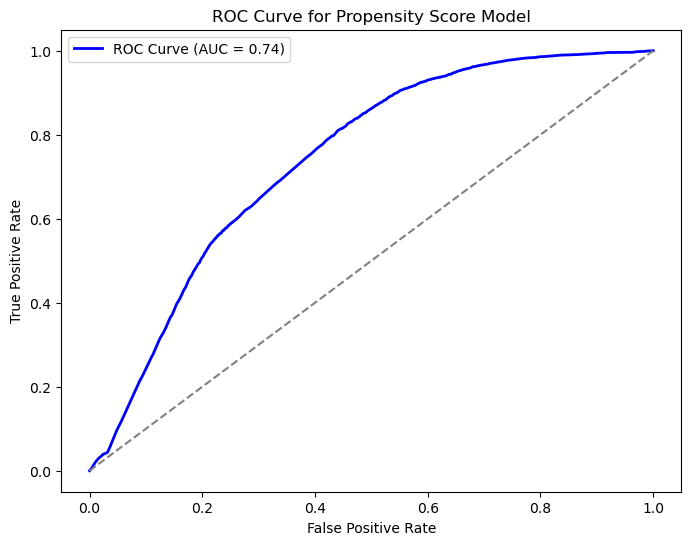

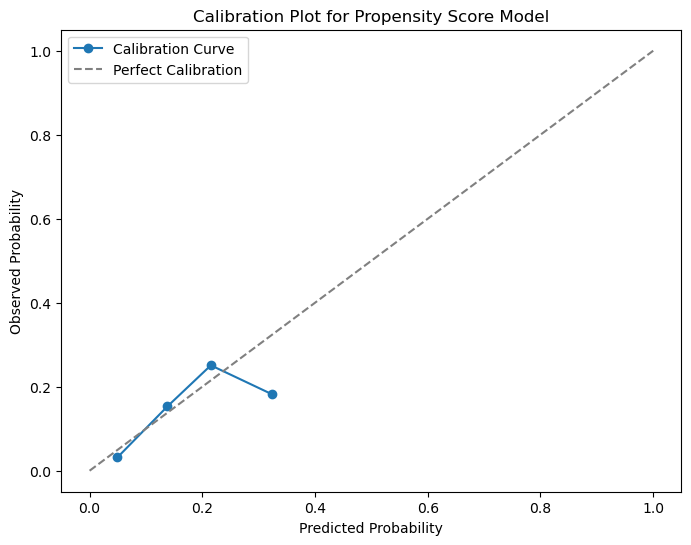

In [10]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc

# ROC-AUC Curve
def plot_roc_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random chance line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Propensity Score Model')
    plt.legend()
    plt.show()

# Calibration Plot
def plot_calibration(y_true, y_pred):
    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=10)

    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Probability')
    plt.title('Calibration Plot for Propensity Score Model')
    plt.legend()
    plt.show()

# Generate the plots
plot_roc_auc(y, df['PROPENSITY_SCORE'])
plot_calibration(y, df['PROPENSITY_SCORE'])


ROC-AUC Curve: The closer the AUC score is to 1.0, the better the model distinguishes between treated and control groups. A score close to 0.5 suggests the model isn’t better than random guessing. As mentioned above, a ROC-AUC score of above 0.7 means that the probability estimator is acceptable.

Calibration Plot: As the points lie close to the diagonal line, the model is well-calibrated, meaning predicted probabilities seem to match actual treatment assignments.

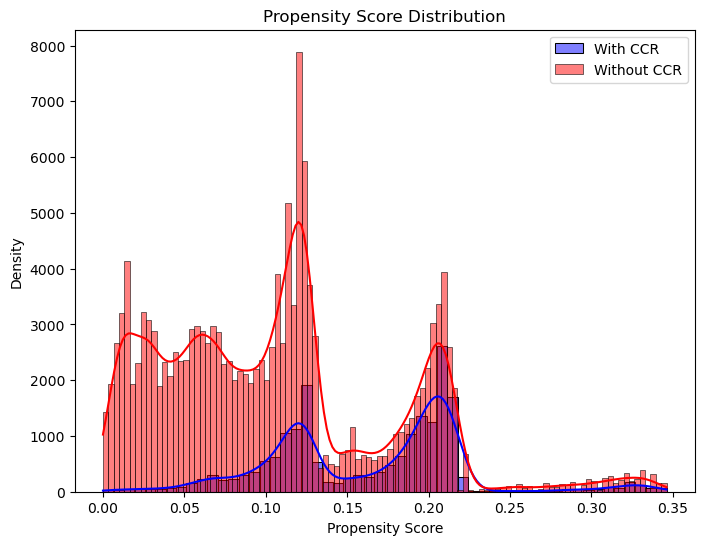

In [11]:
# Check propensity score distribution
plt.figure(figsize=(8, 6))
sns.histplot(df[df['IS_CCR_RATE_TYPE'] == 1]['PROPENSITY_SCORE'], color='blue', label='With CCR', kde=True)
sns.histplot(df[df['IS_CCR_RATE_TYPE'] == 0]['PROPENSITY_SCORE'], color='red', label='Without CCR', kde=True)
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.title("Propensity Score Distribution")
plt.legend()
plt.show()

There's still a large area that is unoverlapped. We can use the Kolmogorov-Smirnov test to formally check overlap.

In [12]:
# Kolmogorov-Smirnov test to formally check overlap
from scipy.stats import ks_2samp

treated_scores = df[df['IS_CCR_RATE_TYPE'] == 1]['PROPENSITY_SCORE']
control_scores = df[df['IS_CCR_RATE_TYPE'] == 0]['PROPENSITY_SCORE']
ks_stat, p_value = ks_2samp(treated_scores, control_scores)
print(f'Kolmogorov-Smirnov Test Statistic (D): {ks_stat:.4f}, p-value: {p_value:.4f}')

if p_value <= 0.05 and ks_stat >= 0.3:
    print("Warning: Poor overlap detected (D >= 0.3, p <= 0.05). Consider trimming or adjusting the model.")
else:
    print("The two distributions are not significantly different, suggesting good overlap.")

Kolmogorov-Smirnov Test Statistic (D): 0.3696, p-value: 0.0000


**Let's trim extreme propensity scores to improve the overlap, by excluding observations outside a propensity score range, in this case let's try excluding scores outside the 15th percentile and the 85th percentile.**

Lower Bound: 0.0318, Upper Bound: 0.2020


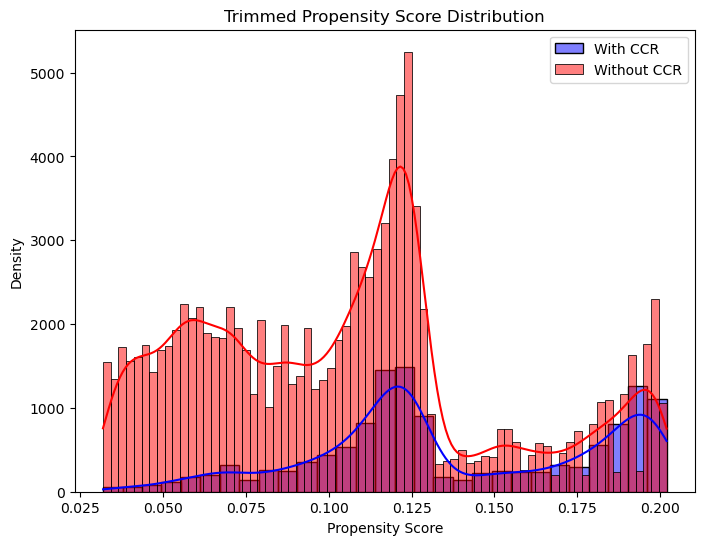

Kolmogorov-Smirnov Test Statistic (Trimmed): 0.2885, p-value: 0.0000
The two distributions are not significantly different, suggesting better overlap after trimming.


In [13]:
# Step 1: Calculate percentiles of the propensity score distribution
lower_percentile = 0.15  # 15th percentile
upper_percentile = 0.85  # 85th percentile

lower_bound = df['PROPENSITY_SCORE'].quantile(lower_percentile)
upper_bound = df['PROPENSITY_SCORE'].quantile(upper_percentile)

print(f'Lower Bound: {lower_bound:.4f}, Upper Bound: {upper_bound:.4f}')

# Step 2: Trim extreme propensity scores
df_trimmed = df[(df['PROPENSITY_SCORE'] >= lower_bound) & (df['PROPENSITY_SCORE'] <= upper_bound)]

# Step 3: Check the distribution of the trimmed data
plt.figure(figsize=(8, 6))
sns.histplot(df_trimmed[df_trimmed['IS_CCR_RATE_TYPE'] == 1]['PROPENSITY_SCORE'], color='blue', label='With CCR', kde=True)
sns.histplot(df_trimmed[df_trimmed['IS_CCR_RATE_TYPE'] == 0]['PROPENSITY_SCORE'], color='red', label='Without CCR', kde=True)
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.title("Trimmed Propensity Score Distribution")
plt.legend()
plt.show()

# Step 4: Re-run the Kolmogorov-Smirnov test after trimming
treated_scores_trimmed = df_trimmed[df_trimmed['IS_CCR_RATE_TYPE'] == 1]['PROPENSITY_SCORE']
control_scores_trimmed = df_trimmed[df_trimmed['IS_CCR_RATE_TYPE'] == 0]['PROPENSITY_SCORE']
ks_stat_trimmed, p_value_trimmed = ks_2samp(treated_scores_trimmed, control_scores_trimmed)

print(f'Kolmogorov-Smirnov Test Statistic (Trimmed): {ks_stat_trimmed:.4f}, p-value: {p_value_trimmed:.4f}')

if p_value_trimmed <= 0.05 and ks_stat_trimmed >= 0.3:
    print("Warning: Poor overlap detected (D >= 0.3, p <= 0.05). Consider trimming or adjusting the model.")
else:
    print("The two distributions are not significantly different, suggesting better overlap after trimming.")


In [14]:
treated = df_trimmed[df_trimmed['IS_CCR_RATE_TYPE'] == 1]
control = df_trimmed[df_trimmed['IS_CCR_RATE_TYPE'] == 0]
# treated: All hotels with a CCR rate (1).
# control: All hotels without a CCR rate (0).
    
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn.fit(control[['PROPENSITY_SCORE']])

distances, indices = nn.kneighbors(treated[['PROPENSITY_SCORE']])
matched_control = control.iloc[indices.flatten()].reset_index(drop=True)
matched_treated = treated.reset_index(drop=True)

ate_psm = (matched_treated['HOTEL_REVENUE'] - matched_control['HOTEL_REVENUE']).mean()
print(f"PSM Estimated ATE: {ate_psm:.4f}")

PSM Estimated ATE: -381.0970


## PSM Method Conclusion:
ATE = -381 means that on average, hotels that use CCR rates in bookings is worse off in revenue by about EUR 381.

We can also use different methods, now that the propensity distribution has good overlap:
1. Inverse Probability Weighting method by assigning higher weights to underrepresented samples to reweight the distribution.
2. Mahalanobis Distance Matching: aside from propensity scores, we can match based on covariates directly. We can consider this method if the weight distributions don't overlap well. This is because we prioritize retaining the data (which the IPW method allows by assigning weights to all hotels), over only the portion which is matched (which the MDM method is about). However, this method can be run as a robustness check against the PSM method and the IPW method.

**METHOD 2: Inverse Probability Weighting method**

In [15]:
import statsmodels.api as sm

# Fit a logistic regression model to estimate the propensity scores
propensity_model = LogisticRegression(solver='liblinear')
propensity_model.fit(X, y)

# Calculate propensity scores
ps = propensity_model.predict_proba(X)[:, 1]

# Trim extreme propensity scores
lower_limit = 0.15
upper_limit = 0.85

ps_clipped = np.clip(ps, lower_limit, upper_limit)

# Step 2: Compute Weights for IPW (1 / Propensity Score for treated, 1 / (1 - Propensity Score) for control)
df['weights'] = np.where(y == 1, 1 / ps_clipped, 1 / (1 - ps_clipped))

# Stabilize weights (to reduce variance)
df['weights'] = df['weights'] * np.mean(y) / np.where(y == 1, ps_clipped, 1 - ps_clipped)

# Check trimmed weight range
print(f'Minimum Trimmed IPW Weight: {ps_clipped.min():.2f}')
print(f'Maximum Trimmed IPW Weight: {ps_clipped.max():.2f}')

# Estimate treatment effect using weighted regression
model = sm.WLS(outcome, sm.add_constant(y), weights=df['weights']).fit()
original_effect = model.params['IS_CCR_RATE_TYPE']
print(f"Original IPW Treatment Effect: {original_effect:.2f}")
print(f"95% CI: [{model.conf_int().loc['IS_CCR_RATE_TYPE', 0]:.2f}, {model.conf_int().loc['IS_CCR_RATE_TYPE', 1]:.2f}]")
print(f"P-value: {model.pvalues['IS_CCR_RATE_TYPE']:.4f}")

Minimum Trimmed IPW Weight: 0.15
Maximum Trimmed IPW Weight: 0.34
Original IPW Treatment Effect: -509.44
95% CI: [-533.34, -485.54]
P-value: 0.0000


Unstabilized Weights Summary:
count    174586.000000
mean          1.704179
std           1.459612
min           1.176471
25%           1.176471
50%           1.176471
75%           1.241638
max           6.666667
Name: weights_unstab, dtype: float64

Stabilized Weights Summary:
count    174586.000000
mean          0.567067
std           1.207439
min           0.155892
25%           0.155892
50%           0.155892
75%           0.173641
max           5.005874
Name: weights_stab, dtype: float64


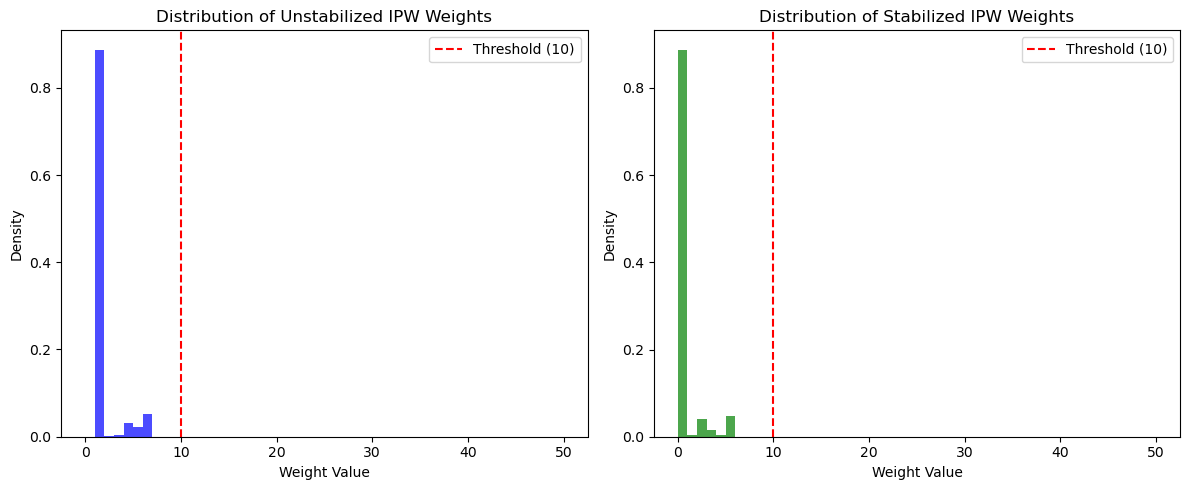

Number of unstabilized weights > 20: 0
Number of stabilized weights > 20: 0


In [16]:
# Calculate IPW weights (unstabilized and stabilized)
df['weights_unstab'] = np.where(y == 1, 1 / ps_clipped, 1 / (1 - ps_clipped))
df['weights_stab'] = df['weights_unstab'] * np.mean(y) / np.where(y == 1, ps_clipped, 1 - ps_clipped)

# Summary statistics of weights
print("Unstabilized Weights Summary:")
print(df['weights_unstab'].describe())
print("\nStabilized Weights Summary:")
print(df['weights_stab'].describe())

# Plot distribution of weights
plt.figure(figsize=(12, 5))

# Unstabilized weights
plt.subplot(1, 2, 1)
plt.hist(df['weights_unstab'], bins=50, range=(0, 50), density=True, alpha=0.7, color='blue')
plt.title('Distribution of Unstabilized IPW Weights')
plt.xlabel('Weight Value')
plt.ylabel('Density')
plt.axvline(x=10, color='red', linestyle='--', label='Threshold (10)')
plt.legend()

# Stabilized weights
plt.subplot(1, 2, 2)
plt.hist(df['weights_stab'], bins=50, range=(0, 50), density=True, alpha=0.7, color='green')
plt.title('Distribution of Stabilized IPW Weights')
plt.xlabel('Weight Value')
plt.ylabel('Density')
plt.axvline(x=10, color='red', linestyle='--', label='Threshold (10)')
plt.legend()

plt.tight_layout()
plt.show()

# Check for extreme weights
extreme_unstab = (df['weights_unstab'] > 20).sum()
extreme_stab = (df['weights_stab'] > 20).sum()
print(f"Number of unstabilized weights > 20: {extreme_unstab}")
print(f"Number of stabilized weights > 20: {extreme_stab}")

**Interpretation:** In both histograms, no weights exceed 10.
This check for the distribution of IPW weights shows that weights are stable, suggesting good overlap and a reliable IPW estimate. Stabilization reduces variance without introducing issues.

In [17]:
# Step : Sensitivity Analysis
def sensitivity_analysis(df, ps_clipped, y, outcome, X, effect_range, outcome_range):
    results = []
    for e_y in effect_range:  # Effect of U on treatment (log-odds scale)
        for e_outcome in outcome_range:  # Effect of U on outcome
            # Simulate unmeasured confounder U (binary, prevalence 0.5)
            U = np.random.binomial(1, 0.5, len(df))
            # Adjust propensity score for U
            logit_ps_clipped = np.log(ps_clipped / (1 - ps_clipped)) + e_y * (U - 0.5)
            ps_adj = 1 / (1 + np.exp(-logit_ps_clipped))
            # Adjust outcome for U
            outcome_adj = outcome + e_outcome * U
            # Recalculate IPW weights
            weights_adj = np.where(y == 1, 1 / ps_adj, 1 / (1 - ps_adj))
            # Stabilize weights
            weights_adj = weights_adj * np.mean(y) / np.where(y == 1, ps_adj, 1 - ps_adj)
            # Re-estimate treatment effect
            model_adj = sm.WLS(outcome_adj, sm.add_constant(y), weights=weights_adj).fit()
            effect_adj = model_adj.params['IS_CCR_RATE_TYPE']
            ci_lower = model_adj.conf_int().loc['IS_CCR_RATE_TYPE', 0]
            ci_upper = model_adj.conf_int().loc['IS_CCR_RATE_TYPE', 1]
            results.append({
                'e_y': e_y,
                'e_outcome': e_outcome,
                'effect': effect_adj,
                'ci_lower': ci_lower,
                'ci_upper': ci_upper,
                'p_value': model_adj.pvalues['IS_CCR_RATE_TYPE']
            })
    return pd.DataFrame(results)

# Define ranges for sensitivity parameters
effect_range = [0, 1, 2, 3]  # Effect of U on treatment assignment (log-odds)
outcome_range = [0, 100, 200, 300]  # Effect of U on hotel revenue

# Run sensitivity analysis
sens_results = sensitivity_analysis(df, ps_clipped, y, outcome, X, effect_range, outcome_range)

# Summarize results
print("\nSensitivity Analysis Results:")
for _, row in sens_results.iterrows():
    print(f"U -> y (log-odds): {row['e_y']:.1f}, U -> outcome: {row['e_outcome']:.1f}, "
          f"Adjusted Effect: {row['effect']:.2f}, 95% CI: [{row['ci_lower']:.2f}, {row['ci_upper']:.2f}], P-value: {row['p_value']:.4f}")

# Check robustness (e.g., does CI exclude 0 under all scenarios?)
robust = sens_results['ci_lower'].apply(lambda x: x > 0).all() or sens_results['ci_upper'].apply(lambda x: x < 0).all()
print(f"\nModel Robust (CI excludes 0 in all scenarios): {robust}")


Sensitivity Analysis Results:
U -> y (log-odds): 0.0, U -> outcome: 0.0, Adjusted Effect: -509.44, 95% CI: [-533.34, -485.54], P-value: 0.0000
U -> y (log-odds): 0.0, U -> outcome: 100.0, Adjusted Effect: -508.63, 95% CI: [-532.53, -484.73], P-value: 0.0000
U -> y (log-odds): 0.0, U -> outcome: 200.0, Adjusted Effect: -509.31, 95% CI: [-533.23, -485.39], P-value: 0.0000
U -> y (log-odds): 0.0, U -> outcome: 300.0, Adjusted Effect: -510.27, 95% CI: [-534.23, -486.31], P-value: 0.0000
U -> y (log-odds): 1.0, U -> outcome: 0.0, Adjusted Effect: -504.63, 95% CI: [-528.93, -480.34], P-value: 0.0000
U -> y (log-odds): 1.0, U -> outcome: 100.0, Adjusted Effect: -551.13, 95% CI: [-577.35, -524.90], P-value: 0.0000
U -> y (log-odds): 1.0, U -> outcome: 200.0, Adjusted Effect: -598.83, 95% CI: [-624.59, -573.08], P-value: 0.0000
U -> y (log-odds): 1.0, U -> outcome: 300.0, Adjusted Effect: -640.14, 95% CI: [-664.13, -616.14], P-value: 0.0000
U -> y (log-odds): 2.0, U -> outcome: 0.0, Adjusted E

**p-value interpretation:** 
A p-value of 0 (or effectively < 0.0001, as it’s rarely exactly 0 due to computational precision) indicates extremely strong evidence against the null hypothesis. In this case, the null hypothesis is that the treatment (IS_CCR_RATE_TYPE) has no effect on the outcome (HOTEL_REVENUE), i.e., the treatment effect is 0.
This suggests that the effect of using CCR rates on hotel revenue is highly statistically significant—there’s virtually no chance the observed effect is due to random variation alone.

**CI interpretation:**
Since the 95% CI does not include 0, it reinforces the p-value’s conclusion. It means that, with 95% confidence, the true treatment effect is not zero and lies within the given range.

**Sensitivity Analysis:** 
The purpose is to test the robustness of the model across different scenarios. The p-value and CI hold under the above scenarios, so the robustness of the model is confirmed.

### IPW model conclusion: 
The IPW model provides very strong evidence (p < 0.0001) that using CCR rates decreases hotel revenue by an estimated EUR 509, with a 95% confidence range of -533 to -486.

**METHOD 3: Mahalanobis Distance Matching**

In [18]:
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

# Covariates, treatment, and outcome
covariates = ['HOTEL_CATEGORY', 'SATISFACTION_SCORE', 'DISTANCE_TO_STATION', 'AVG_DISCOUNT']
X = df[covariates].values
T = df['IS_CCR_RATE_TYPE'].values
Y = df['HOTEL_REVENUE'].values

# Standardize covariates (MDM works better with scaled data)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute covariance matrix
S = np.cov(X_scaled.T)
S_inv = np.linalg.inv(S)

# Split into treated and control
X_treated = X_scaled[T == 1]
X_control = X_scaled[T == 0]
Y_treated = Y[T == 1]
Y_control = Y[T == 0]

# Mahalanobis distance matching (1:1 nearest neighbor)
matches = []
for i, x_t in enumerate(X_treated):
    distances = cdist([x_t], X_control, metric='mahalanobis', VI=S_inv)[0]
    match_idx = np.argmin(distances)
    matches.append((i, match_idx))

# Create matched dataset
matched_treated_idx = [m[0] for m in matches]
matched_control_idx = [m[1] for m in matches]
matched_data = pd.DataFrame({
    'HOTEL_REVENUE': np.concatenate([Y_treated[matched_treated_idx], Y_control[matched_control_idx]]),
    'IS_CCR_RATE_TYPE': np.concatenate([np.ones(len(matched_treated_idx)), np.zeros(len(matched_control_idx))])
})

# Estimate treatment effect
model_mdm = sm.OLS(matched_data['HOTEL_REVENUE'], sm.add_constant(matched_data['IS_CCR_RATE_TYPE'])).fit()
mdm_effect = model_mdm.params['IS_CCR_RATE_TYPE']
print(f"MDM Treatment Effect: {mdm_effect:.2f}")
print(f"95% CI: [{model_mdm.conf_int().loc['IS_CCR_RATE_TYPE', 0]:.2f}, {model_mdm.conf_int().loc['IS_CCR_RATE_TYPE', 1]:.2f}]")
print(f"P-value: {model_mdm.pvalues['IS_CCR_RATE_TYPE']:.4f}")

MDM Treatment Effect: -557.97
95% CI: [-611.01, -504.93]
P-value: 0.0000


**MDM Method Conclusion:**
Earlier we had the IPW method, which measures the Average Treatment Effect across all hotels. Now we have the results from the MDM method which measures the Average Treatment effect on the Treated for the matched hotels. Since the results from both methods align, our confidence from the IPW method is strengthened, that using CCR rates decreases hotel revenue.

**In summary:**
We achieve similar results across all 3 methods, suggesting that our models are robust, taking also quality checks into consideration, such as distribution overlap, sensitivity avalysis, confidence intervals, p-values, as well as visual gauges for common sense check.
We reasonably and safely come to the conclusion that using CCR rates will reduce hotel revenues by, respective of each method as follows:
1. PSM method: -381 EUR
2. IPW method: -509 EUR
3. MDM method: -558 EUR
We believe that the above results are statistically significant. However, they are not necessarily **clinically** significant. This means that if we are to survey a hotel, the negative 560 EUR over 4 years might be negligible to the hotel. 